
# Federated GANBLR Experiments


In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
from dataclasses import dataclass
from typing import List, Dict, Tuple, Any, Optional
import time
import json
import itertools
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss
import warnings, math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.datasets import fetch_openml
from sklearn.naive_bayes import CategoricalNB
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from pathlib import Path
import gc
warnings.filterwarnings("ignore")
tf.random.set_seed(123)

print("TF:", tf.__version__)


TF: 2.16.2


## 1) Dummy Dataset 

In [2]:

# Synthetic discrete data (same shape as earlier smoke tests)
n_train, n_test = 4000, 2000
card = [3, 4, 3, 3, 2]  # [Y, X0, X1, X2, X3]
y_index = 0
PY = np.array([0.5, 0.3, 0.2])

def sample_real(n, rng=np.random.default_rng(0)):
    out = np.zeros((n, 5), dtype=np.int32)
    for t in range(n):
        y = rng.choice(3, p=PY); out[t, 0] = y
        X0 = [np.array([0.05, 0.75, 0.15, 0.05]),
              np.array([0.2,  0.2,  0.5,  0.1]),
              np.array([0.6,  0.1,  0.1,  0.2])][y]
        out[t, 1] = rng.choice(4, p=X0)
        X1 = [np.array([0.1, 0.4, 0.5]),
              np.array([0.6, 0.2, 0.2]),
              np.array([0.2, 0.2, 0.6])][y]
        out[t, 2] = rng.choice(3, p=X1)
        if out[t,1] in (1,2):
            X2 = np.array([0.2, 0.6, 0.2]) if y==0 else (np.array([0.4,0.4,0.2]) if y==1 else np.array([0.2,0.3,0.5]))
        else:
            X2 = np.array([0.6, 0.2, 0.2]) if y==0 else (np.array([0.3,0.5,0.2]) if y==1 else np.array([0.2,0.2,0.6]))
        out[t, 3] = rng.choice(3, p=X2)
        X3 = [np.array([0.55,0.45]), np.array([0.5,0.5]), np.array([0.45,0.55])][y]
        out[t, 4] = rng.choice(2, p=X3)
    return out

train = sample_real(n_train, rng=np.random.default_rng(0))
test  = sample_real(n_test,  rng=np.random.default_rng(1))

print('Train/Test shapes:', train.shape, test.shape)


Train/Test shapes: (4000, 5) (2000, 5)


## 2) Run KDB with configurable k

In [3]:
from base_models.Ganblr import _build_kdb_structure, MLE_KDB, DiscBN_KDB, SimpleGANBLR, GANBLR

# === Set K here ===
k = 2  # try 0, 1, or 2

# Build KDB structure on TRAIN
parents, order = _build_kdb_structure(train, card, y_index, k=k)
print("Order by I(X;Y):", order)
for v in range(len(card)):
    if v == y_index: continue
    print(f"v={v} parents:", parents[v])


Order by I(X;Y): [1, 2, 3, 4]
v=1 parents: []
v=2 parents: [1]
v=3 parents: [1, 2]
v=4 parents: [1, 2]


## 3) Train & evaluate — Variant A (MLE_KDB)

In [4]:
A = MLE_KDB(card, y_index, parents, alpha=1.0)
A.fit(train)
proba_A = A.predict_proba(test)
y_test = test[:, y_index]
acc_A = accuracy_score(y_test, proba_A.argmax(axis=1))
ll_A  = log_loss(y_test, proba_A, labels=list(range(card[y_index])))
print(f"A (MLE_KDB, k={k}): acc={acc_A:.4f}, nll={ll_A:.4f}")


A (MLE_KDB, k=2): acc=0.7455, nll=0.6419


## 4) Train & evaluate — Variant B (DiscBN_KDB, constrained=True)

In [5]:

B1 = DiscBN_KDB(card, y_index, parents, constrained=True, seed=123)
# Warm-start from MLE parameters to align with A (can set jitter_std>0 to move off MLE)
B1.init_from_mle(A, jitter_std=0.0)
B1.fit(train, epochs=80, batch_size=512, l2=1e-5, verbose=1)

proba_B1 = B1.predict_proba(test)
acc_B1 = accuracy_score(y_test, proba_B1.argmax(axis=1))
ll_B1  = log_loss(y_test, proba_B1, labels=list(range(card[y_index])))
print(f"B1 (DiscBN_KDB constrained, k={k}): acc={acc_B1:.4f}, nll={ll_B1:.4f}")


2026-01-14 09:47:03.915043: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2026-01-14 09:47:03.915106: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-14 09:47:03.915110: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-01-14 09:47:03.915251: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-14 09:47:03.915267: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[DiscBN_KDB] Epoch 1/80


2026-01-14 09:47:04.710635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


[DiscBN_KDB] Epoch 1/80 completed: nll=0.5746
[DiscBN_KDB] Epoch 2/80
[DiscBN_KDB] Epoch 2/80 completed: nll=0.5746
[DiscBN_KDB] Epoch 3/80
[DiscBN_KDB] Epoch 3/80 completed: nll=0.5746
[DiscBN_KDB] Epoch 4/80
[DiscBN_KDB] Epoch 4/80 completed: nll=0.5746
[DiscBN_KDB] Epoch 5/80
[DiscBN_KDB] Epoch 5/80 completed: nll=0.5746
[DiscBN_KDB] Epoch 6/80
[DiscBN_KDB] Epoch 6/80 completed: nll=0.5746
[DiscBN_KDB] Epoch 7/80
[DiscBN_KDB] Epoch 7/80 completed: nll=0.5746
[DiscBN_KDB] Epoch 8/80
[DiscBN_KDB] Epoch 8/80 completed: nll=0.5746
[DiscBN_KDB] Epoch 9/80
[DiscBN_KDB] Epoch 9/80 completed: nll=0.5746
[DiscBN_KDB] Epoch 10/80
[DiscBN_KDB] Epoch 10/80 completed: nll=0.5746
[DiscBN_KDB] Epoch 11/80
[DiscBN_KDB] Epoch 11/80 completed: nll=0.5746
[DiscBN_KDB] Epoch 12/80
[DiscBN_KDB] Epoch 12/80 completed: nll=0.5746
[DiscBN_KDB] Epoch 13/80
[DiscBN_KDB] Epoch 13/80 completed: nll=0.5746
[DiscBN_KDB] Epoch 14/80
[DiscBN_KDB] Epoch 14/80 completed: nll=0.5746
[DiscBN_KDB] Epoch 15/80
[DiscBN_K

## 5) Simple GANBLR with MLE

In [6]:
# Instantiate and fit the simplified GANBLR on the example `train` array (Y first column)
simple_ganblr = SimpleGANBLR(alpha=1.0)

X_train_int = train[:, 1:]   # feature columns only
y_train_int = train[:, 0]    # labels (Y)

simple_ganblr.fit(X_train_int, y_train_int, k=2, verbose=1, warmup_epochs=1)

# Evaluate generator predictive performance on held-out `test` (full table with Y in col 0)
if simple_ganblr.generator is None:
	raise RuntimeError("Generator is not initialized. Make sure fit() completed successfully and did not fail.")
proba_gen = simple_ganblr.generator.predict_proba(test)
print("Generator acc on test:", accuracy_score(test[:, 0], proba_gen.argmax(axis=1)))


[SimpleGANBLR] fitted generator (k=2). |Y|=3, features=4
Generator acc on test: 0.7455


## 6) GANBLR Model with $BN^e$

In [7]:
ganblr = GANBLR()
X_train_int = train[:, 1:]   # feature columns only
y_train_int = train[:, 0]    # labels (Y)
ganblr.fit(X_train_int, y_train_int, adversarial=False)
X_test_int = test[:, 1:]     # feature columns only for test
y_test_int = test[:, 0]      # labels (Y) for test
ganblr.evaluate(X_test_int, y_test_int)


[DEBUG] _safe_log_loss is being used (this message appears once)


{'acc': 0.718, 'nll': 0.6493574686741922}

## 7) UCI-ML benchmarks — nursery, car, adult, magic, shuttle

In [8]:
from utils import build_full_table, onehot_all, discretize_train_test_no_leak
from evaluation import run_one_fold_fed_ganblr, _free_locals, _soft_clear_tf_and_ray

rng = np.random.default_rng(7)

# =============================================================================
# Config
# =============================================================================
k_uciml        = 2           # KDB parents (try 0, 1, 2, 3)
test_size      = 0.20        # <-- split ratio (stratified)
random_state   = 2024
max_rows_per_split = 60000   # cap training subset for speed on large sets
epochs_B1      = 10
epochs_B2      = 10
batch_B        = 1024
l2_B           = 1e-5

# Discretization configuration
disc_strategy  = "ef"        # "ef" = equal-frequency (quantile bins via KBinsDiscretizer), "mdlp" = Fayyad-Irani MDL
ef_n_bins      = 12          # used only when disc_strategy == "ef"

# Dataset-specific metadata (target col; optional hint bins for EF)
DATASETS = [
    dict(name="nursery",          alt=["nursery"],                target="class", ef_bins=None),
    dict(name="car",              alt=["car"],                    target="class", ef_bins=None),
    dict(name="adult",            alt=["adult"],                  target="class", ef_bins=10),
    dict(name="magic",            alt=["magic"],                  target="class", ef_bins=12),
    dict(name="shuttle",          alt=["shuttle"],                target="class", ef_bins=12),
]

def evaluate_all(name, X_df, y_sr, ef_bins_hint=None, disc_strategy_local=None, test_size_local=None):
    """
    name: dataset name (for logging)
    ef_bins_hint: per-dataset EF bins override (None -> use ef_n_bins)
    disc_strategy_local: 'ef' or 'mdlp' (None-> use global disc_strategy)
    test_size_local: override split ratio (None-> use global test_size)
    """
    strategy = disc_strategy if disc_strategy_local is None else disc_strategy_local
    ef_bins_use = ef_n_bins if ef_bins_hint is None else ef_bins_hint
    ts = test_size if test_size_local is None else test_size_local

    # Drop NA rows first
    df = pd.concat([X_df, y_sr.rename("target")], axis=1).dropna()
    X = df.drop(columns=["target"])
    y = df["target"]

    # --- Discretize FULL dataset ---
    X_int, y_int, card_feat, classes = discretize_train_test_no_leak(X, y, strategy=strategy, ef_bins=ef_bins_use)
    num_classes = len(classes)

    # --- Stratified split on already-discretized arrays ---
    Xtr_int, Xte_int, ytr_int, yte_int = train_test_split(
        X_int, y_int, test_size=ts, random_state=random_state, stratify=y_int
    )

    # Cap size if large (train only)
    if len(Xtr_int) > max_rows_per_split:
        idx = np.random.default_rng(1).choice(len(Xtr_int), size=max_rows_per_split, replace=False)
        Xtr_int = Xtr_int[idx]
        ytr_int = ytr_int[idx]

    # card with y first
    card_all = [num_classes] + list(card_feat)
    y_index_local = 0

    # Compose full tables with y in first column
    train_arr, test_arr = build_full_table(ytr_int, yte_int, Xtr_int, Xte_int)

    # KDB structure on TRAIN (requires earlier section functions)
    parents, order = _build_kdb_structure(train_arr, card_all, y_index_local, k=k_uciml)

    # --- A) MLE_KDB ---
    A = MLE_KDB(card_all, y_index_local, parents, alpha=1.0)
    A.fit(train_arr)
    proba_A = A.predict_proba(test_arr)
    acc_A = accuracy_score(yte_int, proba_A.argmax(axis=1))
    ll_A  = log_loss(yte_int, proba_A, labels=list(range(num_classes)))

    # --- B1) DiscBN_KDB constrained ---
    B1 = DiscBN_KDB(card_all, y_index_local, parents, constrained=True, seed=123)
    B1.init_from_mle(A, jitter_std=0.0)
    B1.fit(train_arr, epochs=epochs_B1, batch_size=batch_B, l2=l2_B, verbose=0)
    proba_B1 = B1.predict_proba(test_arr)
    acc_B1 = accuracy_score(yte_int, proba_B1.argmax(axis=1))
    ll_B1  = log_loss(yte_int, proba_B1, labels=list(range(num_classes)))

    # --- B2) DiscBN_KDB unconstrained ---
    B2 = DiscBN_KDB(card_all, y_index_local, parents, constrained=False, seed=123)
    B2.fit(train_arr, epochs=epochs_B2, batch_size=batch_B, l2=l2_B, verbose=0)
    proba_B2 = B2.predict_proba(test_arr)
    acc_B2 = accuracy_score(yte_int, proba_B2.argmax(axis=1))
    ll_B2  = log_loss(yte_int, proba_B2, labels=list(range(num_classes)))

    # --- sklearn baselines ---
    nb = CategoricalNB()
    nb.fit(Xtr_int, ytr_int)
    proba_nb = nb.predict_proba(Xte_int)
    acc_nb = accuracy_score(yte_int, proba_nb.argmax(axis=1))
    ll_nb  = log_loss(yte_int, proba_nb, labels=list(range(num_classes)))
    
    Xtr_oh = onehot_all(Xtr_int, card_feat)
    Xte_oh = onehot_all(Xte_int, card_feat)
    lr = LogisticRegression(max_iter=1000, multi_class='multinomial')
    lr.fit(Xtr_oh, ytr_int)
    proba_lr = lr.predict_proba(Xte_oh)
    acc_lr = accuracy_score(yte_int, proba_lr.argmax(axis=1))
    ll_lr  = log_loss(yte_int, proba_lr, labels=list(range(num_classes)))

    return dict(
        dataset=name, k=k_uciml, n_train=len(Xtr_int), n_test=len(Xte_int),
        acc_A=acc_A, nll_A=ll_A,
        acc_B1=acc_B1, nll_B1=ll_B1,
        acc_B2=acc_B2, nll_B2=ll_B2,
        acc_nb=acc_nb, nll_nb=ll_nb,
        acc_lr=acc_lr, nll_lr=ll_lr
    )

# =============================================================================
# Run benchmarks
# =============================================================================
#UNCOMMENT TO RUN THE MODELS
# results = []
# for spec in DATASETS:
#     name = spec["name"]; target = spec["target"]; ef_bins_hint = spec.get("ef_bins", None)
#     try:
#         print(f"\n=== Dataset: {name} (k={k_uciml}, strategy={disc_strategy}, ef_bins={ef_bins_hint or ef_n_bins}, test_size={test_size}) ===")
#         X_df, y_sr = fetch_openml_safely(name=name, target=target, alt_names=spec.get("alt", []), version=1)
#         row = evaluate_all(name, X_df, y_sr, ef_bins_hint=ef_bins_hint)
#         print(f"  A (MLE_KDB)             acc={row['acc_A']:.4f}  nll={row['nll_A']:.4f}")
#         print(f"  B1 (DiscBN constrained) acc={row['acc_B1']:.4f}  nll={row['nll_B1']:.4f}")
#         print(f"  B2 (DiscBN unconstr.)   acc={row['acc_B2']:.4f}  nll={row['nll_B2']:.4f}")
#         print(f"  sklearn NB              acc={row['acc_nb']:.4f}  nll={row['nll_nb']:.4f}")
#         print(f"  sklearn LR              acc={row['acc_lr']:.4f}  nll={row['nll_lr']:.4f}")
#         results.append(row)
#     except Exception as e:
#         print(f"  !! Skipping {name} due to error: {repr(e)}")

# df_results = pd.DataFrame(results, columns=[
#     "dataset","k","n_train","n_test",
#     "acc_A","nll_A","acc_B1","nll_B1","acc_B2","nll_B2","acc_nb","nll_nb","acc_lr","nll_lr"
# ])
# df_results


## 8)  Cross validation TSTR

In [9]:
from sklearn.model_selection import RepeatedStratifiedKFold
from pathlib import Path

# ---- Config (close to train-test cell) ----
n_splits_cv     = 2     # K folds
n_repeats_cv    = 2      # N rounds
random_state_cv = 2025

def evaluate_all_cv(name, X_df, y_sr, ef_bins_hint=None, disc_strategy_local=None,
                    n_splits=None, n_repeats=None, random_state_cv_local=None):
    """
    Same spirit as evaluate_all(...) but runs repeated stratified K-fold CV on discretized FULL dataset.
    Returns:
        df_folds  — per-fold results (one row per fold)
        df_summary_like — one-row DataFrame with mean metrics, columns aligned to train-test df_results
                          (plus std columns in df_summary for completeness)
    """
    strategy = disc_strategy if disc_strategy_local is None else disc_strategy_local
    ef_bins_use = ef_n_bins if ef_bins_hint is None else ef_bins_hint
    K = n_splits if n_splits is not None else n_splits_cv
    R = n_repeats if n_repeats is not None else n_repeats_cv
    rs = random_state_cv if random_state_cv_local is None else random_state_cv_local

    # Drop NA rows first (same as train-test)
    df = pd.concat([X_df, y_sr.rename("target")], axis=1).dropna()
    X = df.drop(columns=["target"])
    y = df["target"]

    # Discretize FULL dataset (identical helper)
    X_int, y_int, card_feat, classes = discretize_train_test_no_leak(X, y, strategy=strategy, ef_bins=ef_bins_use)
    num_classes = len(classes)

    # Repeated Stratified CV
    rskf = RepeatedStratifiedKFold(n_splits=K, n_repeats=R, random_state=rs)

    folds = []
    fold_id = 0
    for rep_idx, (tr_idx, te_idx) in enumerate(rskf.split(X_int, y_int)):
        fold_id += 1
        Xtr_int, Xte_int = X_int[tr_idx], X_int[te_idx]
        ytr_int, yte_int = y_int[tr_idx], y_int[te_idx]

        # Optional cap on training set (same variable name)
        if len(Xtr_int) > max_rows_per_split:
            sel = np.random.default_rng(1).choice(len(Xtr_int), size=max_rows_per_split, replace=False)
            Xtr_int = Xtr_int[sel]; ytr_int = ytr_int[sel]

        # Card and full tables (identical pattern)
        card_all = [num_classes] + list(card_feat)
        y_index_local = 0
        train_arr, test_arr = build_full_table(ytr_int, yte_int, Xtr_int, Xte_int)

        # KDB structure on TRAIN
        parents, order = _build_kdb_structure(train_arr, card_all, y_index_local, k=k_uciml)

        # --- A) MLE_KDB ---
        A = MLE_KDB(card_all, y_index_local, parents, alpha=1.0)
        A.fit(train_arr)
        proba_A = A.predict_proba(test_arr)
        acc_A = accuracy_score(yte_int, proba_A.argmax(axis=1))
        nll_A = log_loss(yte_int, proba_A, labels=list(range(num_classes)))

        # --- B1) Disc constrained ---
        B1 = DiscBN_KDB(card_all, y_index_local, parents, constrained=True, seed=123)
        B1.init_from_mle(A, jitter_std=0.0)
        B1.fit(train_arr, epochs=epochs_B1, batch_size=batch_B, l2=l2_B, verbose=0)
        proba_B1 = B1.predict_proba(test_arr)
        acc_B1 = accuracy_score(yte_int, proba_B1.argmax(axis=1))
        nll_B1 = log_loss(yte_int, proba_B1, labels=list(range(num_classes)))

        # --- B2) Disc unconstrained ---
        B2 = DiscBN_KDB(card_all, y_index_local, parents, constrained=False, seed=123)
        B2.fit(train_arr, epochs=epochs_B2, batch_size=batch_B, l2=l2_B, verbose=0)
        proba_B2 = B2.predict_proba(test_arr)
        acc_B2 = accuracy_score(yte_int, proba_B2.argmax(axis=1))
        nll_B2 = log_loss(yte_int, proba_B2, labels=list(range(num_classes)))

        # --- sklearn baselines (same as train-test) ---
        nb = CategoricalNB()
        nb.fit(Xtr_int, ytr_int)
        proba_nb = nb.predict_proba(Xte_int)
        acc_nb = accuracy_score(yte_int, proba_nb.argmax(axis=1))
        nll_nb = log_loss(yte_int, proba_nb, labels=list(range(num_classes)))

        Xtr_oh = onehot_all(Xtr_int, card_feat)
        Xte_oh = onehot_all(Xte_int, card_feat)
        lr = LogisticRegression(max_iter=1000, multi_class='multinomial')
        lr.fit(Xtr_oh, ytr_int)
        proba_lr = lr.predict_proba(Xte_oh)
        acc_lr = accuracy_score(yte_int, proba_lr.argmax(axis=1))
        nll_lr = log_loss(yte_int, proba_lr, labels=list(range(num_classes)))

        folds.append(dict(
            dataset=name, k=k_uciml, fold=fold_id, n_train=len(Xtr_int), n_test=len(Xte_int),
            acc_A=acc_A, nll_A=nll_A,
            acc_B1=acc_B1, nll_B1=nll_B1,
            acc_B2=acc_B2, nll_B2=nll_B2,
            acc_nb=acc_nb, nll_nb=nll_nb,
            acc_lr=acc_lr, nll_lr=nll_lr
        ))

    df_folds = pd.DataFrame(folds)

    # Summary with SAME column names as train-test (means), for easy side-by-side comparison
    summary_row = dict(
        dataset=name, k=k_uciml,
        n_train=int(df_folds["n_train"].mean()), n_test=int(df_folds["n_test"].mean()),
        acc_A=df_folds["acc_A"].mean(),  nll_A=df_folds["nll_A"].mean(),
        acc_B1=df_folds["acc_B1"].mean(), nll_B1=df_folds["nll_B1"].mean(),
        acc_B2=df_folds["acc_B2"].mean(), nll_B2=df_folds["nll_B2"].mean(),
        acc_nb=df_folds["acc_nb"].mean(), nll_nb=df_folds["nll_nb"].mean(),
        acc_lr=df_folds["acc_lr"].mean(), nll_lr=df_folds["nll_lr"].mean()
    )
    df_summary_like = pd.DataFrame([summary_row])

    return df_folds, df_summary_like

# ---- Run CV over DATASETS (printing to match train-test format; now means) ----
# all_folds, all_summary_like = [], []
# for spec in DATASETS:
#     name = spec["name"]; target = spec["target"]; ef_bins_hint = spec.get("ef_bins", None)
#     print(f"\n=== CV: {name} (k={k_uciml}, strategy={disc_strategy}, ef_bins={ef_bins_hint or ef_n_bins}, "
#           f"{n_repeats_cv}x{n_splits_cv}-fold) ===")
#     try:
#         # Fetch full data
#         X_df, y_sr = fetch_openml_safely(name=name, target=target, alt_names=spec.get("alt", []), version=1)
#         df_folds, df_sum = evaluate_all_cv(name, X_df, y_sr, ef_bins_hint=ef_bins_hint)
#         all_folds.append(df_folds); all_summary_like.append(df_sum)

#         row = df_sum.iloc[0]
#         print(f"  A (MLE_KDB)             acc={row['acc_A']:.4f}  nll={row['nll_A']:.4f}")
#         print(f"  B1 (DiscBN constrained) acc={row['acc_B1']:.4f}  nll={row['nll_B1']:.4f}")
#         print(f"  B2 (DiscBN unconstr.)   acc={row['acc_B2']:.4f}  nll={row['nll_B2']:.4f}")
#         print(f"  sklearn NB              acc={row['acc_nb']:.4f}  nll={row['nll_nb']:.4f}")
#         print(f"  sklearn LR              acc={row['acc_lr']:.4f}  nll={row['nll_lr']:.4f}")
#     except Exception as e:
#         print(f"  !! Skipping {name} due to error: {repr(e)}")

# df_cv_folds = pd.concat(all_folds, ignore_index=True) if all_folds else pd.DataFrame()
# df_results_cv = pd.concat(all_summary_like, ignore_index=True) if all_summary_like else pd.DataFrame()

# # Save CSVs
# out_folds = Path("kdb_cv_perfold.csv")
# out_sum   = Path("kdb_cv_summary.csv")
# df_cv_folds.to_csv(out_folds, index=False)
# df_results_cv.to_csv(out_sum, index=False)
# print(f"\nWrote per-fold results to: {out_folds}")
# print(f"Wrote summary (train-test-like columns) to: {out_sum}")

# # Display summary DataFrame (same columns as train-test df_results)
# df_results_cv


## 9) Run TSTR on all models with cross-validation

In [10]:
from evaluation import compare_real_central_fed_cv_all_datasets

# DATASETS = [
#     # dict(name="chess",          alt=["chess"],                target="class", ef_bins=None),
#     # dict(name="pokerhand",              alt=["pokerhand"],                    target="class", ef_bins=None),
#     dict(name="covertype",            alt=["covtype"],                  target="class", ef_bins=None),
#     dict(name="connect-4",            alt=["connect"],                  target="class", ef_bins=None),
#     dict(name="credit-g",          alt=["credit"],                target="class", ef_bins=None),
# ]

# DATASETS = [
#     dict(name="Letter_recog",    alt=["letter_recog"],          target="class", ef_bins=None),
#     dict(name="sign",            alt=["sign"],                  target="class", ef_bins=None),
#     dict(name="satellite",       alt=["satelite"],              target="class", ef_bins=None),
#     dict(name="loan",            alt=["loan"],                  target="class", ef_bins=None),
# ]

compare_cfg: dict[str, Any] = {
    "n_splits": 2,
    "n_repeats": 2,
    "random_state": 2025,
    "disc_strategy_use": None,
    "ef_bins_default": 12,
    "k_global": 2,
    "epochs_gan": 10,
    "batch_gan": 64,
    "warmup_gan": 1,
    "num_clients": 5,
    "num_rounds": 5,
    "dir_alpha": 0.2,
    "gamma": 0.6,
    "local_epochs": 3,
    "batch_size": 64,
    "disc_epochs": 1,
    "cpt_mix": 0.25,
    "alpha_dir": 1e-3,
    "cap_train": 60000,
}
# df_cmp_folds, df_cmp_sum = compare_real_central_fed_cv_all_datasets(DATASETS, **compare_cfg)
# print("\nComparison summary:")
# display(df_cmp_sum)

## 10) Plot TSTR Results of all models

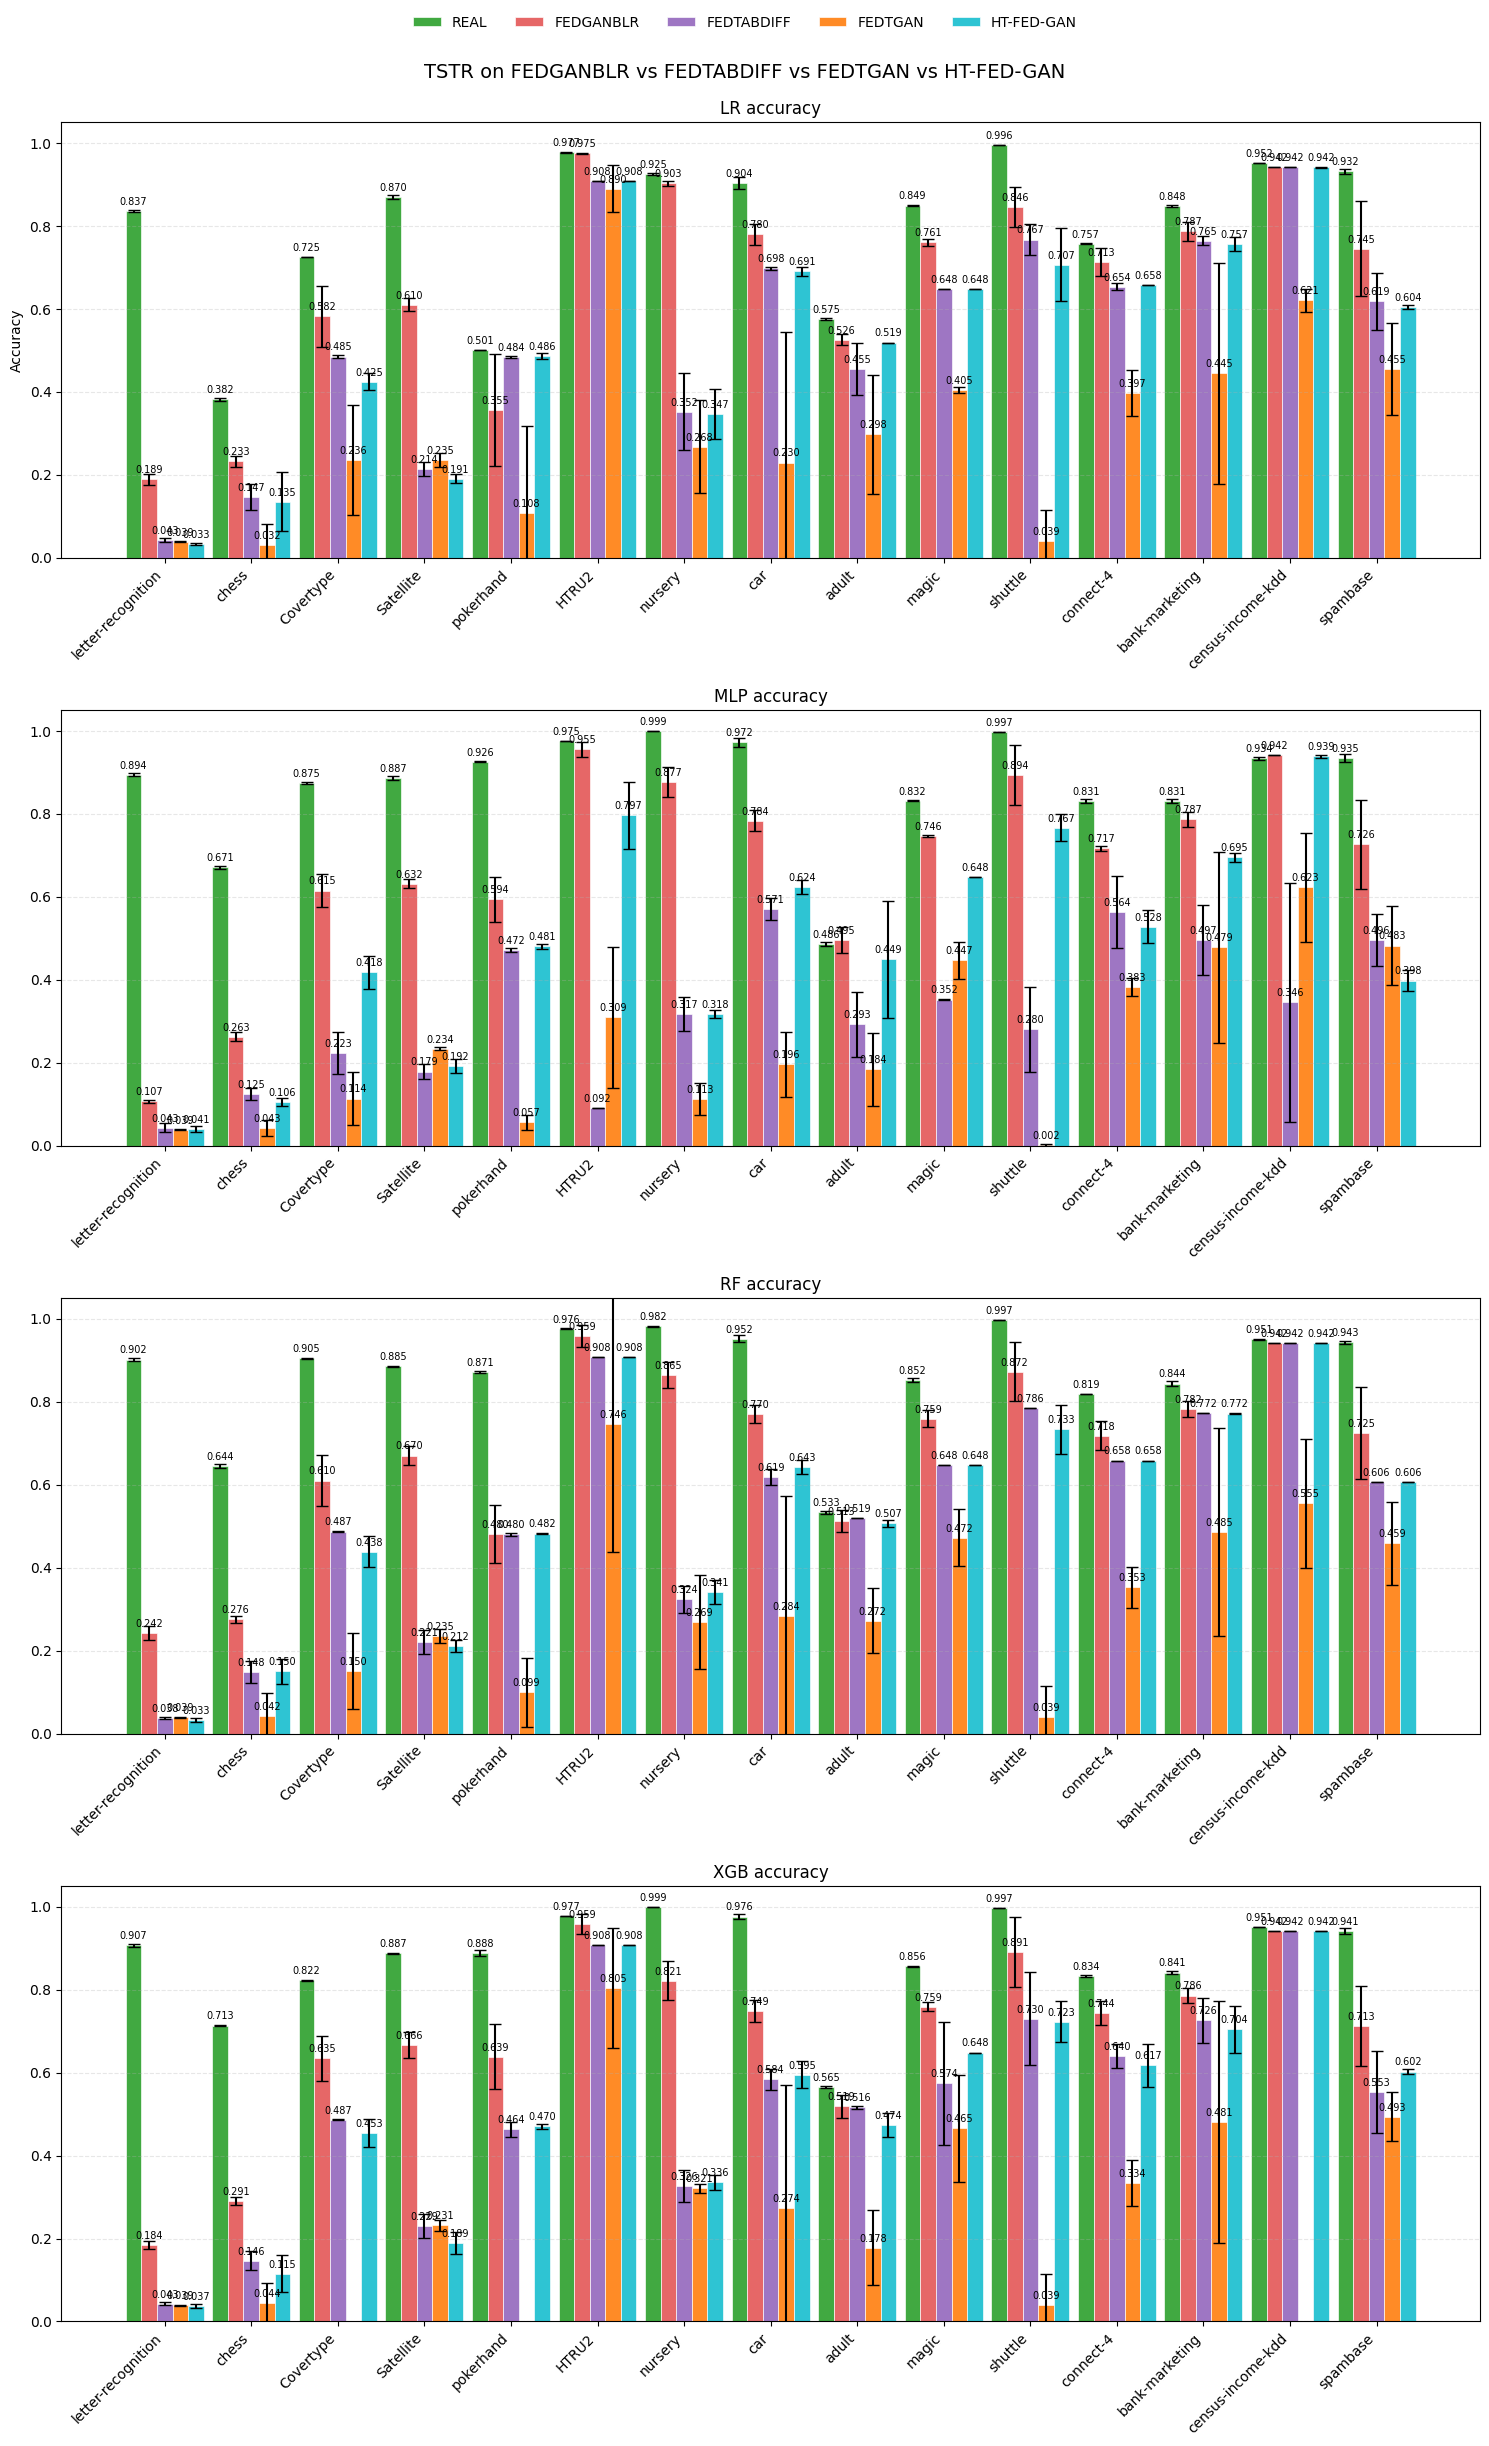

In [11]:
from pathlib import Path

# Improved plotting: use all four CSVs, each tagged by its model
folds_path = Path("final_results/cv_compare_perfold_nal.csv")   # FEDGANBLR (our method)
ftd_path   = Path("final_results/fedtabdiff_results.csv")       # FEDTABDIFF
htf_path   = Path("final_results/htfedgan_results.csv")         # HT-FED-GAN
ftg_path   = Path("final_results/fedtgan_results.csv")          # FEDTGAN

def _load_results(path: Path, model_name: str,
                  rename_map: dict[str, str] | None = None,
                  keep_cols: list[str] | None = None) -> Optional[pd.DataFrame]:
    if not path.exists():
        print(f"[plot] {path} not found; skipping {model_name}.")
        return None
    df = pd.read_csv(path)
    
    if keep_cols:
        base_cols = ["dataset"]
        if "fold" in df.columns:
            base_cols.append("fold")
        missing = [c for c in keep_cols if c not in df.columns]
        if missing:
            print(f"[plot] {model_name}: missing columns {missing}")
        selected = base_cols + [c for c in keep_cols if c in df.columns]
        selected = list(dict.fromkeys(selected))
        df = df.loc[:, selected].copy()
    if rename_map:
        df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})
    df["model"] = model_name
    return df

real_colmap = {
    "acc_real_lr": "tstr_acc_lr",
    "acc_real_mlp": "tstr_acc_mlp",
    "acc_real_rf": "tstr_acc_rf",
    "acc_real_xgb": "tstr_acc_xgb",
    "nll_real_lr": "tstr_nll_lr",
    "nll_real_mlp": "tstr_nll_mlp",
    "nll_real_rf": "tstr_nll_rf",
    "nll_real_xgb": "tstr_nll_xgb",
}
fed_colmap = {
    "acc_fed_lr": "tstr_acc_lr",
    "acc_fed_mlp": "tstr_acc_mlp",
    "acc_fed_rf": "tstr_acc_rf",
    "acc_fed_xgb": "tstr_acc_xgb",
    "nll_fed_lr": "tstr_nll_lr",
    "nll_fed_mlp": "tstr_nll_mlp",
    "nll_fed_rf": "tstr_nll_rf",
    "nll_fed_xgb": "tstr_nll_xgb",
}
parts: list[pd.DataFrame] = []
for args in [
    (folds_path, "real", dict(rename_map=real_colmap, keep_cols=list(real_colmap.keys()))),
    (folds_path, "fed", dict(rename_map=fed_colmap)),
    (ftd_path, "fedtabdiff", None),
    (ftg_path, "fedtgan", None),
    (htf_path, "htfedgan", None),
]:
    path, model_name, extra = args
    extra = extra or {}
    df_part = _load_results(path, model_name, **extra)
    if df_part is not None and not df_part.empty:
        parts.append(df_part)

df_all = pd.concat(parts, ignore_index=True, sort=False)

# Treat any purely numeric dataset labels (e.g. 1,2,3,4) as invalid for plotting
def _is_numeric_dataset(val) -> bool:
    s = str(val).strip()
    if s == "" or s.lower() == "nan":
        return False
    return s.isdigit()

# Drop those rows entirely so they don't affect stats or labels
df_all = df_all[~df_all["dataset"].apply(_is_numeric_dataset)].copy()

models = ["real", "fed", "fedtabdiff", "fedtgan", "htfedgan"]
colors = {
    "real": "#2CA02C",
    "fed": "#E45656",
    "fedtabdiff": "#9467BD",
    "fedtgan": "#FF7F0E",
    "htfedgan": "#17BECF",
}
display_names = {
    "real": "REAL",
    "fed": "FEDGANBLR",
    "fedtabdiff": "FEDTABDIFF",
    "fedtgan": "FEDTGAN",
    "htfedgan": "HT-FED-GAN",
}
classifiers = ("lr", "mlp", "rf", "xgb")

if "dataset" not in df_all.columns:
    raise KeyError("Expected a 'dataset' column in result CSVs.")

# Build x‑axis labels only from non‑numeric dataset names
datasets = list(dict.fromkeys(df_all["dataset"].tolist()))

x = np.arange(len(datasets))
width = 0.18

def _mean_std_for(model: str, col: str, dataset: str):
    """Compute mean/std of a metric column for a given model and dataset."""
    if col not in df_all.columns:
        return np.nan, 0.0
    mask = (df_all["model"] == model) & (df_all["dataset"] == dataset)
    vals = df_all.loc[mask, col].dropna().to_numpy()
    if vals.size == 0:
        return np.nan, 0.0
    return float(np.nanmean(vals)), float(np.nanstd(vals, ddof=1))

def plot_grouped_by_classifier_all_csvs():
    fig, axes = plt.subplots(len(classifiers), 1, figsize=(15, 6*len(classifiers)), sharey=True)
    fig.suptitle('TSTR on FEDGANBLR vs FEDTABDIFF vs FEDTGAN vs HT-FED-GAN', fontsize=14, y=0.995)

    if len(classifiers) == 1:
        axes = [axes]

    for ax, clf in zip(axes, classifiers):
        offsets = np.linspace(-((len(models)-1)/2)*width, ((len(models)-1)/2)*width, num=len(models))
        col = f"tstr_acc_{clf}"
        for off, m in zip(offsets, models):
            means, stds = [], []
            for ds in datasets:
                mu, sd = _mean_std_for(m, col, ds)
                means.append(mu); stds.append(sd)
            bars = ax.bar(
                x + off, means, yerr=stds, width=width,
                label=display_names.get(m, m.upper()),
                color=colors[m], alpha=0.9, edgecolor="white", ecolor="black",
                capsize=4, linewidth=0.5,
            )
            for rect, mu in zip(bars, means):
                if np.isfinite(mu):
                    ax.text(
                        rect.get_x() + rect.get_width()/2.0,
                        rect.get_height() + 0.01,
                        f"{mu:.3f}",
                        ha="center", va="bottom", fontsize=7,
                    )

        ax.set_title(f"{clf.upper()} accuracy")
        ax.set_xticks(x)
        ax.set_xticklabels(datasets, rotation=45, ha="right")
        ax.set_ylim(0.0, 1.05)
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)

    axes[0].set_ylabel("Accuracy")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.02), ncols=len(models), frameon=False)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.35)
    plt.show()

# Call the new plotting function
plot_grouped_by_classifier_all_csvs()


In [12]:
tstr = pd.read_csv("final_results/tstr_classifier_rows_model_cols.csv")
tstr[['fed','fedtabdiff','fedtgan','htfedgan']].mean(axis=0)


fed           0.676096
fedtabdiff    0.484245
fedtgan       0.291257
htfedgan      0.522380
dtype: float64

## 11) Fidelity, Coverage and Privacy


In [13]:
from utils import fetch_openml_safely
from evaluation import _build_real_df, calculate_coverage, calculate_fidelity, calculate_dcr_privacy, _build_syn_df


In [14]:
from utils import fetch_openml_safely
from federated_models.FedGanblr import build_global_kdb_from_gm

def _load_model_json(p: Path) -> dict | None:
    if not p.exists():
        return None
    with p.open("r") as f:
        d = json.load(f)

    def _norm1(x: np.ndarray, axis=None):
        x = np.asarray(x, dtype=np.float64)
        x = np.clip(x, 1e-12, None)
        s = x.sum(axis=axis, keepdims=True)
        s[s == 0] = 1.0
        return x / s

    # Normalize to numpy arrays and renormalize probabilities
    d["py"] = _norm1(np.asarray(d["py"], dtype=np.float64))
    d["thetas"] = {
        int(k): _norm1(np.asarray(v, dtype=np.float64), axis=1)
        for k, v in d["thetas"].items()
    }
    d["card"] = list(map(int, d["card"]))
    d["y_index"] = int(d["y_index"])
    d["parents"] = {int(k): list(map(int, v)) for k, v in d["parents"].items()}
    return d

def _build_kdb_from_payload(payload: dict) -> MLE_KDB:
    # Reuse the existing helper to attach params without fitting
    gen = build_global_kdb_from_gm(
        gm=dict(py=payload["py"], thetas=payload["thetas"]),
        card=payload["card"],
        parents=payload["parents"],  # parents exclude Y in payload
        y_index=payload["y_index"]
    )
    return gen

def _sample_full_from_payload(payload: dict, n: int, rng: np.random.Generator | None = None) -> np.ndarray:
    gen = _build_kdb_from_payload(payload)
    return gen.sample(n=n, rng=(rng or np.random.default_rng(0)), order=None, return_y=True)

def _build_real_df(X: np.ndarray, y: np.ndarray) -> pd.DataFrame:
    # Treat all features as categorical (discretized integers)
    cols = ["y"] + [f"f{j}" for j in range(X.shape[1])]
    arr = np.column_stack([y, X]).astype(np.int32)
    return pd.DataFrame(arr, columns=cols)

def _build_syn_df(syn_full: np.ndarray) -> pd.DataFrame:
    y_syn = syn_full[:, 0]
    X_syn = syn_full[:, 1:]
    return _build_real_df(X_syn, y_syn)

def _metric_row(dataset: str, fold: int, method: str, real_df: pd.DataFrame, syn_df: pd.DataFrame) -> dict:
    # All columns are categorical in discretized space
    all_cols = list(real_df.columns)
    numeric_cols: list[str] = []              # none (all categorical)
    categorical_cols: list[str] = all_cols    # include label 'y' as categorical too

    col_fid, row_fid, agg_fid = calculate_fidelity(real_df, syn_df, numeric_cols, categorical_cols)
    coverage = calculate_coverage(real_df, syn_df, numeric_cols, categorical_cols)

    dcr_sample_size = min(10000, len(real_df)) if len(real_df) > 10000 else None
    dcr = calculate_dcr_privacy(real_df, syn_df, numeric_cols, sample_size=dcr_sample_size)

    return dict(
        dataset=dataset, fold=fold, method=method,
        fidelity_col=col_fid, fidelity_row=row_fid, fidelity_agg=agg_fid,
        coverage=coverage, privacy_dcr=dcr
    )

def compute_fold_metrics(root: Path = Path("fold_artifacts")) -> pd.DataFrame:
    """Compute and write metrics incrementally per fold."""
    if not root.exists():
        raise FileNotFoundError(f"Missing folder: {root.resolve()}. Run the CV pipeline first.")

    out_csv = Path("fold_artifacts/metrics_fidelity_coverage_privacy.csv")
    header_cols = ["dataset", "fold", "method", "fidelity_col", "fidelity_row", "fidelity_agg", "coverage", "privacy_dcr"]
    
    # Initialize CSV with header if it doesn't exist
    if not out_csv.exists() or out_csv.stat().st_size == 0:
        pd.DataFrame(columns=header_cols).to_csv(out_csv, index=False)
    
    rows_written = 0
    for ds_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        dataset = ds_dir.name
        for fold_dir in sorted([p for p in ds_dir.iterdir() if p.is_dir() and p.name.startswith("fold_")]):
            try:
                fold = int(fold_dir.name.split("_")[-1])
            except Exception:
                fold = None

            data_npz = fold_dir / "data.npz"
            if not data_npz.exists():
                continue
            
            dd = np.load(data_npz, allow_pickle=True)
            Xtr_int = dd["Xtr_int"]; ytr_int = dd["ytr_int"]
            real_df = _build_real_df(Xtr_int, ytr_int)

            candidates = {
                "fed": fold_dir / "fed_global_model.json",
            }
            for method, path in candidates.items():
                payload = _load_model_json(path)
                if payload is None:
                    continue
                
                syn_full = _sample_full_from_payload(payload, n=len(Xtr_int), rng=np.random.default_rng(0))
                syn_df = _build_syn_df(syn_full)
                row_data = _metric_row(dataset, fold if fold is not None else -1, method, real_df, syn_df)
                
                # Append row incrementally
                pd.DataFrame([row_data], columns=header_cols).to_csv(
                    out_csv, mode="a", header=False, index=False
                )
                rows_written += 1

    print(f"Wrote {rows_written} rows to: {out_csv}")
    
    # Read and return the full dataframe for summary
    df_metrics = pd.read_csv(out_csv).sort_values(["dataset","fold","method"]).reset_index(drop=True)
    return df_metrics

def summarize_fold_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """Group by dataset/method and report mean ± std for each metric, plus counts."""
    metrics = ["fidelity_col", "fidelity_row", "fidelity_agg", "coverage", "privacy_dcr"]
    grp = df.groupby(["dataset", "method"])
    mean_df = grp[metrics].mean().rename(columns={m: f"{m}_mean" for m in metrics})
    std_df  = grp[metrics].std(ddof=1).fillna(0.0).rename(columns={m: f"{m}_std" for m in metrics})
    n_df    = grp.size().to_frame("n_folds")
    out = mean_df.join(std_df).join(n_df).reset_index()

    # Also provide pretty mean ± std columns for quick display
    for m in metrics:
        out[f"{m}_mean_std"] = (out[f"{m}_mean"].round(4)).astype(str) + " ± " + (out[f"{m}_std"].round(4)).astype(str)

    out_csv = Path("fold_artifacts/metrics_fidelity_coverage_privacy_summary.csv")
    out.to_csv(out_csv, index=False)
    print(f"Wrote summary: {out_csv}")
    return out

#df_metrics = compute_fold_metrics()

In [15]:
df_metrics = pd.read_csv("fold_artifacts/metrics_fidelity_coverage_privacy.csv")
df_metrics_summary = summarize_fold_metrics(df_metrics)
#filter df to only include and fedganblr
df_filtered = df_metrics_summary[df_metrics_summary["method"].isin(["fed"])]

def add_metrics_data(path, df_filtered):
    if path.exists():
        df_ftd_raw = pd.read_csv(path)
        # guard required columns
        required_cols = {"dataset","fidelity_agg","coverage","privacy_dcr"}
        if required_cols.issubset(df_ftd_raw.columns):
            grp = df_ftd_raw.groupby("dataset")
            df_ftd_sum = grp.agg(
                fidelity_agg_mean=("fidelity_agg","mean"),
                fidelity_agg_std=("fidelity_agg","std"),
                coverage_mean=("coverage","mean"),
                coverage_std=("coverage","std"),
                privacy_dcr_mean=("privacy_dcr","mean"),
                privacy_dcr_std=("privacy_dcr","std"),
                n_folds=("fidelity_agg","size"),
            ).reset_index()
            # pretty columns to match summarize_fold_metrics output style
            for col in ("fidelity_agg","coverage","privacy_dcr"):
                df_ftd_sum[f"{col}_mean_std"] = (
                    df_ftd_sum[f"{col}_mean"].round(4).astype(str)
                    + " ± "
                    + df_ftd_sum[f"{col}_std"].fillna(0.0).round(4).astype(str)
                )
            import re
            string = path.name
            match = re.search(r"^([^_]+)", string)
            if match:
                model_name = match.group(1)

            df_ftd_sum["method"] = model_name
            # select matching display columns
            df_ftd_display = df_ftd_sum[[
                "dataset","method","n_folds",
                "fidelity_agg_mean_std","coverage_mean_std","privacy_dcr_mean_std"
            ]]
            # concat with existing filtered (central_ganblr, fed)
            df_filtered = pd.concat([df_filtered[[
                "dataset","method","n_folds",
                "fidelity_agg_mean_std","coverage_mean_std","privacy_dcr_mean_std"
            ]], df_ftd_display], ignore_index=True)
        else:
            print("CSV missing required columns; skipping merge.")
    else:
        print(f"{path} not found; skipping FEDTABDIFF merge.")
    return df_filtered

ftd_path = Path("final_results/fedtabdiff_results.csv")
ht_path = Path("final_results/htfedgan_results.csv")
ftg_path = Path("final_results/fedtgan_results.csv")
df_filtered = add_metrics_data(ftd_path, df_filtered)
df_filtered = add_metrics_data(ht_path, df_filtered)
df_filtered = add_metrics_data(ftg_path, df_filtered)

df_filtered = df_filtered.sort_values(['dataset']).set_index('dataset')
display(df_filtered)
# df_filtered.drop(columns='n_folds', inplace=True)
# df_filtered.to_csv('fidelity_coverage_privacy.csv')


Wrote summary: fold_artifacts/metrics_fidelity_coverage_privacy_summary.csv


,method,n_folds,fidelity_agg_mean_std,coverage_mean_std,privacy_dcr_mean_std
dataset,,,,,
Covertype,fedtabdiff,4,0.0846 ± 0.0092,0.2102 ± 0.0063,4.1829 ± 0.069
Covertype,htfedgan,4,0.0772 ± 0.0001,0.8675 ± 0.0005,3.873 ± 0.0
Covertype,fedtgan,4,0.0525 ± 0.0005,0.0664 ± 0.0214,3.1623 ± 0.0
HTRU2,fedtabdiff,4,0.6296 ± 0.025,1.0 ± 0.0,1.1838 ± 0.076
HTRU2,htfedgan,4,0.7566 ± 0.0019,1.0 ± 0.0,8.4917 ± 0.1227
HTRU2,fedtgan,4,0.4849 ± 0.0092,0.0981 ± 0.0517,0.6119 ± 0.154
Satellite,fedtabdiff,4,0.0784 ± 0.0049,0.1258 ± 0.0032,8.0 ± 0.0
Satellite,htfedgan,4,0.0732 ± 0.0006,0.9413 ± 0.0037,7.6158 ± 0.0
Satellite,fedtgan,4,0.0112 ± 0.0,0.0004 ± 0.0004,6.0 ± 0.0


## 12) JSD and WD

In [16]:
from evaluation import compute_distributional_metrics

def compute_fold_jsd_wd(root: Path = Path("fold_artifacts")) -> pd.DataFrame:
    """
    Load saved models for each dataset/fold, sample synthetic data,
    compute JSD/WD vs real (features-only), and write incrementally.
    """
    if not root.exists():
        raise FileNotFoundError(f"Missing folder: {root.resolve()}. Run the CV pipeline first.")

    out_csv = root / "jsd_wd_perfold.csv"
    header_cols = ["dataset", "fold", "method", "jsd", "wd"]
    
    # Initialize CSV with header if it doesn't exist
    if not out_csv.exists() or out_csv.stat().st_size == 0:
        pd.DataFrame(columns=header_cols).to_csv(out_csv, index=False)
    
    rows_written = 0
    for ds_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        dataset = ds_dir.name
        for fold_dir in sorted([p for p in ds_dir.iterdir() if p.is_dir() and p.name.startswith("fold_")]):
            try:
                fold = int(fold_dir.name.split("_")[-1])
            except Exception:
                fold = -1

            data_npz = fold_dir / "data.npz"
            if not data_npz.exists():
                continue

            # Real reference: use TRAIN fold
            dd = np.load(data_npz, allow_pickle=True)
            Xtr_int = dd["Xtr_int"]; ytr_int = dd["ytr_int"]
            real_df = _build_real_df(Xtr_int, ytr_int)
            real_feat = real_df.drop(columns=["y"], errors="ignore")

            # Models saved per fold
            candidates = {
                "fed":            fold_dir / "fed_global_model.json",
            }

            for method, path in candidates.items():
                payload = _load_model_json(path)
                if payload is None:
                    continue
                
                # Sample same size as training fold
                syn_full = _sample_full_from_payload(payload, n=len(Xtr_int), rng=np.random.default_rng(0))
                syn_df = _build_syn_df(syn_full)
                syn_feat = syn_df.drop(columns=["y"], errors="ignore")

                m = compute_distributional_metrics(real_feat, syn_feat)
                row_data = dict(
                    dataset=dataset, fold=fold, method=method,
                    jsd=m["jsd_mean"], wd=m["wd_mean"]
                )
                
                # Append row incrementally
                pd.DataFrame([row_data], columns=header_cols).to_csv(
                    out_csv, mode="a", header=False, index=False
                )
                rows_written += 1

    print(f"Wrote {rows_written} rows to: {out_csv}")
    
    # Read and return the full dataframe
    df = pd.read_csv(out_csv).sort_values(["dataset","fold","method"]).reset_index(drop=True)
    return df

def summarize_jsd_wd(df: pd.DataFrame) -> pd.DataFrame:
    """
    Mean ± std of JSD/WD by dataset and method.
    Writes CSV: fold_artifacts/jsd_wd_summary.csv
    """
    grp = df.groupby(["dataset","method"])
    mean_df = grp[["jsd","wd"]].mean().rename(columns={"jsd":"jsd_mean","wd":"wd_mean"})
    std_df  = grp[["jsd","wd"]].std(ddof=1).rename(columns={"jsd":"jsd_std","wd":"wd_std"}).fillna(0.0)
    n_df    = grp.size().to_frame("n_folds")
    out = mean_df.join(std_df).join(n_df).reset_index()

    # Pretty columns
    out["jsd_mean_std"] = out["jsd_mean"].round(4).astype(str) + " ± " + out["jsd_std"].round(4).astype(str)
    out["wd_mean_std"]  = out["wd_mean"].round(4).astype(str) + " ± " + out["wd_std"].round(4).astype(str)

    out_csv = Path("fold_artifacts/jsd_wd_summary.csv")
    out.to_csv(out_csv, index=False)
    print(f"Wrote summary: {out_csv}")
    return out

In [17]:
#df_jsdwd = compute_fold_jsd_wd(Path("fold_artifacts"))
df_jsdwd = pd.read_csv('fold_artifacts/jsd_wd_perfold.csv')

def add_jsd_wd_data(path, df):
    if path.exists():
        df_ftd_raw = pd.read_csv(path)
        # Require jsd_mean & wd_mean columns
        req = {"dataset","fold","jsd_mean","wd_mean"}
        if req.issubset(df_ftd_raw.columns):
            def _parse_fold(x):
                try:
                    # accept 'fold_01' etc.
                    if isinstance(x,str) and "fold_" in x:
                        return int(x.split("_")[-1])
                    return int(x)
                except Exception:
                    return -1
            string = path.name
            import re
            match = re.search(r"^([^_]+)", string)
            if match: 
                model_name = match.group(1)
            df_ftd = pd.DataFrame({
                "dataset": df_ftd_raw["dataset"],
                "fold": df_ftd_raw["fold"].map(_parse_fold),
                "method": model_name,
                "jsd": df_ftd_raw["jsd_mean"],
                "wd": df_ftd_raw["wd_mean"],
            })
            # align dtypes
            df_ftd["jsd"] = pd.to_numeric(df_ftd["jsd"], errors="coerce")
            df_ftd["wd"]  = pd.to_numeric(df_ftd["wd"], errors="coerce")
            # Combine with existing (central_mle / central_ganblr / fed)
            df = pd.concat([df, df_ftd], ignore_index=True)
        else:
            print("CSV missing required jsd_mean/wd_mean; skipping JSD/WD merge.")
    else:
        print(f"{path} not found; skipping FEDTABDIFF JSD/WD merge.")
    return df

df_jsdwd = add_jsd_wd_data(ftd_path, df_jsdwd)
df_jsdwd = add_jsd_wd_data(ht_path, df_jsdwd)
df_jsdwd = add_jsd_wd_data(ftg_path, df_jsdwd)

df_jsdwd_summary = summarize_jsd_wd(df_jsdwd)
df_jsdwd_summary = df_jsdwd_summary[df_jsdwd_summary["method"].isin(['central_ganblr', 'fed','fedtgan', 'fedtabdiff', 'htfedgan'])]
cols = ["dataset","method","n_folds","jsd_mean_std","wd_mean_std"]
display(df_jsdwd_summary[cols].sort_values(["dataset","method"]))
df_jsdwd_summary = df_jsdwd_summary[cols].sort_values(["dataset","method"])
df_jsdwd_summary.to_csv("jsd_wd.csv")


Wrote summary: fold_artifacts/jsd_wd_summary.csv


,dataset,method,n_folds,jsd_mean_std,wd_mean_std
0,Covertype,fed,8,0.0501 ± 0.0029,0.3677 ± 0.3303
1,Covertype,fedtabdiff,4,0.5989 ± 0.0072,0.2504 ± 0.0
2,Covertype,fedtgan,4,0.6719 ± 0.0006,0.308 ± 0.0081
3,Covertype,htfedgan,4,0.608 ± 0.0002,0.3258 ± 0.0001
4,HTRU2,fed,8,0.0009 ± 0.0001,0.0873 ± 0.0809
5,HTRU2,fedtabdiff,4,0.5402 ± 0.0062,0.4388 ± 0.0
6,HTRU2,fedtgan,4,0.5924 ± 0.0289,0.2159 ± 0.0448
7,HTRU2,htfedgan,4,0.5225 ± 0.0061,0.1028 ± 0.0009
8,Satellite,fed,8,0.0063 ± 0.0003,0.0981 ± 0.0874
9,Satellite,fedtabdiff,4,0.5369 ± 0.0078,0.1266 ± 0.0


In [18]:
df_jsdwd = add_jsd_wd_data(ftd_path, df_jsdwd)
df_jsdwd = add_jsd_wd_data(ht_path, df_jsdwd)
df_jsdwd = add_jsd_wd_data(ftg_path, df_jsdwd)

df_jsdwd_summary = summarize_jsd_wd(df_jsdwd)
df_jsdwd_summary = df_jsdwd_summary[df_jsdwd_summary["method"].isin(['central_ganblr', 'fed','fedtgan', 'fedtabdiff', 'htfedgan'])]
cols = ["dataset","method","n_folds","jsd_mean_std","wd_mean_std"]
display(df_jsdwd_summary[cols].sort_values(["dataset","method"]))
df_jsdwd_summary = df_jsdwd_summary[cols].sort_values(["dataset","method"])
df_jsdwd_summary.to_csv("jsd_wd.csv")

Wrote summary: fold_artifacts/jsd_wd_summary.csv


,dataset,method,n_folds,jsd_mean_std,wd_mean_std
0,Covertype,fed,8,0.0501 ± 0.0029,0.3677 ± 0.3303
1,Covertype,fedtabdiff,8,0.5989 ± 0.0067,0.2504 ± 0.0
2,Covertype,fedtgan,8,0.6719 ± 0.0006,0.308 ± 0.0075
3,Covertype,htfedgan,8,0.608 ± 0.0002,0.3258 ± 0.0001
4,HTRU2,fed,8,0.0009 ± 0.0001,0.0873 ± 0.0809
5,HTRU2,fedtabdiff,8,0.5402 ± 0.0058,0.4388 ± 0.0
6,HTRU2,fedtgan,8,0.5924 ± 0.0268,0.2159 ± 0.0414
7,HTRU2,htfedgan,8,0.5225 ± 0.0057,0.1028 ± 0.0008
8,Satellite,fed,8,0.0063 ± 0.0003,0.0981 ± 0.0874
9,Satellite,fedtabdiff,8,0.5369 ± 0.0072,0.1266 ± 0.0


## 13) Ablation Studies

In [19]:
def _prepare_split_for(
    name: str = "magic",
    target: str = "class",
    test_size: float = 0.20,
    random_state: int = 2024,
    ef_bins: int = 10,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, List[int], int]:
    X_df, y_sr = fetch_openml_safely(name=name, target=target, alt_names=[name])
    df = pd.concat([X_df, y_sr.rename("target")], axis=1).dropna()
    X = df.drop(columns=["target"])
    y = df["target"]
    Xtr_df, Xte_df, ytr_sr, yte_sr = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    Xtr_int, Xte_int, ytr_int, yte_int, card_feat, classes = discretize_train_test_no_leak(
        Xtr_df, ytr_sr, Xte_df, yte_sr, strategy="ef", ef_bins=ef_bins
    )
    num_classes = len(classes)
    return Xtr_int, Xte_int, ytr_int, yte_int, card_feat, num_classes

def _jsd_wd_features(real_df: pd.DataFrame, syn_df: pd.DataFrame):
    real_feat = real_df.drop(columns=["y"], errors="ignore")
    syn_feat  = syn_df.drop(columns=["y"],  errors="ignore")
    m = compute_distributional_metrics(real_feat, syn_feat)
    return float(m["jsd_mean"]), float(m["wd_mean"])

def _eval_fidelity_coverage_privacy(real_df: pd.DataFrame, syn_df: pd.DataFrame):
    # all columns treated categorical here (discretized)
    numeric_cols: list[str] = []
    categorical_cols = real_df.columns.tolist()
    col_fid, row_fid, agg_fid = calculate_fidelity(real_df, syn_df, numeric_cols, categorical_cols)
    coverage = calculate_coverage(real_df, syn_df, numeric_cols, categorical_cols)
    dcr = calculate_dcr_privacy(real_df, syn_df, numeric_cols)
    return dict(fidelity_col=col_fid, fidelity_row=row_fid, fidelity_agg=agg_fid, coverage=coverage, privacy_dcr=dcr)


In [ ]:

def run_fed_sweep_on_dataset_incremental(
    dataset: str,
    grid: dict,
    repeats: int = 1,
    cap_train: int | None = 10000,
    base_random_state: int = 2024,
    output_dir: Path = Path("ablation_studies"),
):
    Xtr_int, Xte_int, ytr_int, yte_int, card_feat, num_classes = _prepare_split_for(
        name=dataset, target="class", test_size=0.20, random_state=base_random_state, ef_bins=10
    )
    if cap_train is not None and len(Xtr_int) > cap_train:
        sel = np.random.default_rng(1).choice(len(Xtr_int), size=cap_train, replace=False)
        Xtr_int, ytr_int = Xtr_int[sel], ytr_int[sel]

    real_df = _build_real_df(Xtr_int, ytr_int)

    # Build stable header list once
    grid_keys = list(grid.keys())                 # keep declared order
    header_cols = ["rep"] + grid_keys + [
        "time_sec", "fidelity_col", "fidelity_row", "fidelity_agg",
        "coverage", "privacy_dcr", "acc_lr", "acc_mlp", "acc_rf", "acc_xgb", "jsd", "wd"
    ]

    output_file = output_dir / f"fed_ganblr_sweep_{dataset}.csv"
    output_dir.mkdir(parents=True, exist_ok=True)

    # Write header only if file is missing or empty
    if (not output_file.exists()) or (output_file.stat().st_size == 0):
        pd.DataFrame(columns=header_cols).to_csv(output_file, index=False)

    # Unpack grid values
    keys, vals = zip(*grid.items()) if grid else ([], [])

    for combo in itertools.product(*vals) if vals else [()]:
        cfg = dict(zip(keys, combo)) if combo else {}
        for rep in range(repeats):
            t0 = time.time()
            # Predeclare big refs so they exist in finally
            res = None
            gm = None
            syn_full = None
            syn_df = None
            fid_cov_priv = dict(fidelity_col=np.nan, fidelity_row=np.nan, fidelity_agg=np.nan,
                                coverage=np.nan, privacy_dcr=np.nan)
            jsd = np.nan
            wd = np.nan
            row = None
            try:
                # Run federated simulation with this config
                res = run_one_fold_fed_ganblr(
                    Xtr_int, ytr_int, Xte_int, yte_int, card_feat, num_classes,
                    k_global=cfg.get("k", 2),
                    num_clients=cfg.get("num_clients", 5),
                    num_rounds=cfg.get("num_rounds", 10),
                    dir_alpha=cfg.get("dir_alpha", 0.2),
                    gamma=cfg.get("gamma", 0.6),
                    local_epochs=cfg.get("local_epochs", 3),
                    batch_size=cfg.get("batch_size", 256),
                    disc_epochs=cfg.get("disc_epochs", 1),
                    cpt_mix=cfg.get("cpt_mix", 0.25),
                    beta=cfg.get("beta", 0.5),
                    alpha_dir=cfg.get("alpha_dir", 1e-3),
                    cap_train=None
                )

                # Compute fidelity/coverage/privacy from aggregated global model (if any)
                gm = res.get("fed_global_model", None)
                if isinstance(gm, dict):
                    syn_full = _sample_full_from_payload(gm, n=len(Xtr_int), rng=np.random.default_rng(0))
                    syn_df = _build_syn_df(syn_full)
                    fid_cov_priv = _eval_fidelity_coverage_privacy(real_df, syn_df)
                    jsd, wd = _jsd_wd_features(real_df, syn_df)

                # Build row dict matching header order
                row = {
                    "rep": rep,
                    **cfg,
                    "time_sec": res.get("train_time_sec", time.time() - t0) if isinstance(res, dict) else (time.time() - t0),
                    "fidelity_col": fid_cov_priv["fidelity_col"],
                    "fidelity_row": fid_cov_priv["fidelity_row"],
                    "fidelity_agg": fid_cov_priv["fidelity_agg"],
                    "coverage": fid_cov_priv["coverage"],
                    "privacy_dcr": fid_cov_priv["privacy_dcr"],
                    "acc_lr": (res.get("acc_lr", np.nan) if isinstance(res, dict) else np.nan),
                    "acc_mlp": (res.get("acc_mlp", np.nan) if isinstance(res, dict) else np.nan),
                    "acc_rf": (res.get("acc_rf", np.nan) if isinstance(res, dict) else np.nan),
                    "acc_xgb": (res.get("acc_xgb", np.nan) if isinstance(res, dict) else np.nan),
                    "jsd": jsd,
                    "wd": wd,
                }

                # Append one row with consistent column order (missing keys -> NaN)
                pd.DataFrame([row], columns=header_cols).to_csv(
                    output_file, mode="a", header=False, index=False
                )
                print(f"Appended row for cfg={cfg}, rep={rep}")

            finally:
                # Explicitly drop large intermediates and clear TF/Ray/GC
                _free_locals(res, gm, syn_full, syn_df, row, fid_cov_priv)
                try:
                    del res, gm, syn_full, syn_df, row, fid_cov_priv
                except Exception:
                    pass
                _soft_clear_tf_and_ray()
                try:
                    gc.collect()
                except Exception:
                    pass

    print(f"Completed incremental saving for dataset: {dataset}")


small_grid = dict(
    k=[0, 1, 2],
    gamma=[0.0, 0.3, 0.6, 1.0],
    cpt_mix=[0, 0.1, 0.25, 0.5, 0.75, 1],
    beta = [0, 0.25, 0.5, 0.75, 1]
)

datasets = ['adult', 'magic', 'nursery']
# for dataset in datasets:
#      run_fed_sweep_on_dataset_incremental(dataset, small_grid, repeats=1, cap_train=None)



In [ ]:
# Load all ablation study results
ablation_files = [
    "fed_ganblr_sweep_adult.csv",
     "fed_ganblr_sweep_magic.csv",
     "fed_ganblr_sweep_nursery.csv",
]

# Read and combine all results
all_results = []
for file in ablation_files:
    try:
        df = pd.read_csv(f"ablation_studies/{file}")
        dataset_name = file.replace("fed_ganblr_sweep_", "").replace(".csv", "")
        df['dataset'] = dataset_name
        all_results.append(df)
        print(f"Loaded {len(df)} rows from {file}")
    except FileNotFoundError:
        print(f"File {file} not found")

if all_results:
    combined_df = pd.concat(all_results, ignore_index=True)
    print(f"\nTotal combined rows: {len(combined_df)}")
    
    # Calculate average TSTR accuracy across all classifiers
    tstr_cols = ['acc_lr', 'acc_mlp', 'acc_rf', 'acc_xgb']
    
    # Remove rows with all NaN TSTR values
    valid_mask = combined_df[tstr_cols].notna().any(axis=1)
    valid_df = combined_df[valid_mask].copy()
    print(f"Rows with valid TSTR results: {len(valid_df)}")
    
    # Calculate mean TSTR accuracy (ignoring NaN values)
    valid_df['avg_tstr_acc'] = valid_df[tstr_cols].mean(axis=1)
    
    # Group by hyperparameter configuration and calculate mean performance
    hyperparam_cols = ['k', 'gamma', 'cpt_mix']
    
    # Aggregate results by configuration
    config_results = valid_df.groupby(hyperparam_cols).agg({
        'avg_tstr_acc': ['mean', 'std', 'count'],
        'acc_lr': 'mean',
        'acc_mlp': 'mean', 
        'acc_rf': 'mean',
        'acc_xgb': 'mean',
        'fidelity_agg': 'mean',
        'coverage': 'mean',
        'privacy_dcr': 'mean',
        'time_sec': 'mean'
    }).round(4)
    
    # Flatten column names
    config_results.columns = ['_'.join(col).strip() for col in config_results.columns]
    config_results = config_results.reset_index()
    
    # Sort by average TSTR accuracy (descending)
    config_results = config_results.sort_values('avg_tstr_acc_mean', ascending=False)
    
    print("\n=== TOP 10 HYPERPARAMETER CONFIGURATIONS ===")
    print("Ranked by average TSTR accuracy across all classifiers and datasets\n")
    
    top_configs = pd.concat([config_results.head(5), config_results.tail(5)])
    
    for i, (idx, row) in enumerate(top_configs.iterrows(), 1):
        print(f"Rank {i}:")
        print(f"  k={row['k']}, gamma={row['gamma']}, cpt_mix={row['cpt_mix']}")
        print(f"  Avg TSTR Accuracy: {row['avg_tstr_acc_mean']:.4f} ± {row['avg_tstr_acc_std']:.4f}")
        print(f"  LR: {row['acc_lr_mean']:.4f}, MLP: {row['acc_mlp_mean']:.4f}, RF: {row['acc_rf_mean']:.4f}, XGB: {row['acc_xgb_mean']:.4f}")
        print(f"  Fidelity: {row['fidelity_agg_mean']:.4f}, Coverage: {row['coverage_mean']:.4f}")
        print(f"  Privacy DCR: {row['privacy_dcr_mean']:.4f}, Time: {row['time_sec_mean']:.1f}s")
        print(f"  Trials: {int(row['avg_tstr_acc_count'])}\n")
    
    # Extract the best configuration
    best_config = config_results.iloc[0]
    
    print("=== RECOMMENDED BEST CONFIGURATION ===")
    print(f"k = {int(best_config['k'])}")
    print(f"gamma = {best_config['gamma']}")
    print(f"cpt_mix = {best_config['cpt_mix']}")
    print(f"\nExpected Performance:")
    print(f"  Average TSTR Accuracy: {best_config['avg_tstr_acc_mean']:.4f}")
    print(f"  Individual Classifiers:")
    print(f"    - Logistic Regression: {best_config['acc_lr_mean']:.4f}")
    print(f"    - MLP: {best_config['acc_mlp_mean']:.4f}")
    print(f"    - Random Forest: {best_config['acc_rf_mean']:.4f}")
    print(f"    - XGBoost: {best_config['acc_xgb_mean']:.4f}")
    
    
else:
    print("No ablation study files found!")

Loaded 96 rows from fed_ganblr_sweep_adult.csv
Loaded 72 rows from fed_ganblr_sweep_magic.csv
Loaded 72 rows from fed_ganblr_sweep_nursery.csv

Total combined rows: 240
Rows with valid TSTR results: 240

=== TOP 10 HYPERPARAMETER CONFIGURATIONS ===
Ranked by average TSTR accuracy across all classifiers and datasets

Rank 1:
  k=2.0, gamma=0.3, cpt_mix=0.75
  Avg TSTR Accuracy: 0.8556 ± 0.0563
  LR: 0.8665, MLP: 0.8514, RF: 0.8519, XGB: 0.8525
  Fidelity: 0.9397, Coverage: 1.0000
  Privacy DCR: 1.9226, Time: 105.3s
  Trials: 2

Rank 2:
  k=1.0, gamma=0.0, cpt_mix=1.0
  Avg TSTR Accuracy: 0.8548 ± 0.0599
  LR: 0.8548, MLP: 0.8496, RF: 0.8575, XGB: 0.8571
  Fidelity: 0.9408, Coverage: 1.0000
  Privacy DCR: 1.8965, Time: 117.6s
  Trials: 2

Rank 3:
  k=1.0, gamma=1.0, cpt_mix=1.0
  Avg TSTR Accuracy: 0.8536 ± 0.0467
  LR: 0.8637, MLP: 0.8551, RF: 0.8478, XGB: 0.8477
  Fidelity: 0.9526, Coverage: 1.0000
  Privacy DCR: 1.8909, Time: 100.4s
  Trials: 2

Rank 4:
  k=2.0, gamma=0.0, cpt_mix=1.0

In [ ]:
import pandas as pd
from pathlib import Path
from datetime import datetime

repo_root = Path("/Users/macbook/Desktop/Projects/federated_tabular_data_generator/FedGANBLR")
fed_path = repo_root / "final_results" / "fedtabdiff_results.csv"
wd_path = repo_root / "jsd_wd_results.csv"

df_fed = pd.read_csv(fed_path)
df_wd = pd.read_csv(wd_path)

# build mapping from dataset (lowercased) -> wd_mean (take fold_01 rows)
wd_map = {row["dataset"].strip().lower(): float(row["wd_mean"]) for _, row in df_wd.iterrows()}

# backup original
bak = fed_path.with_suffix(f".bak.{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}")
fed_path.replace(bak)  # move original to backup path

# reload (from backup path) to preserve original ordering/format
df_fed = pd.read_csv(bak)

# replace wd_mean for any dataset present in wd_map (apply same value across folds)
def replace_wd(row):
    key = str(row.get("dataset", "")).strip().lower()
    return wd_map.get(key, row.get("wd_mean"))

df_fed["wd_mean"] = df_fed.apply(replace_wd, axis=1)

# write updated CSV to original location
df_fed.to_csv(fed_path, index=False)
print(f"Wrote updated file: {fed_path} (backup moved to: {bak})")

Wrote updated file: /Users/macbook/Desktop/Projects/federated_tabular_data_generator/FedGANBLR/final_results/fedtabdiff_results.csv (backup moved to: /Users/macbook/Desktop/Projects/federated_tabular_data_generator/FedGANBLR/final_results/fedtabdiff_results.bak.20260113T224607Z)




**Prompt for Image Generation:**

Create a professional, clean technical diagram illustrating a federated learning framework for tabular data generation called "FedGAN-BLR". The diagram should have a white background with a modern, academic style suitable for a research paper.

**Layout:**
- Horizontal layout with clients on both the left and right sides, and a central server in the middle
- 3 client boxes positioned vertically on the left side (labeled "Client 1", "Client 2", "Client 3")
- 2 client boxes positioned vertically on the right side (labeled "Client 4", "Client 5")
- 1 larger server box in the center (labeled "Server (Global)")

**Each Client Box Contains:**
- A rounded rectangle container with light blue background (#E3F2FD) and gray border
- Inside each box: a small Bayesian Network graph structure
- At the top of the graph: one orange/amber circular node labeled "Y" (representing the class/target variable)
- Below: 4 blue circular nodes in a row labeled "X₁", "X₂", "X₃", "X₄" (representing feature variables)
- Directed arrows pointing from Y down to each X node (showing class-conditional dependencies)
- Small horizontal arrows connecting adjacent X nodes left-to-right (showing KDB feature dependencies: X₁→X₂→X₃→X₄)
- Below the BN graph: a small text annotation showing "Local Loss: 𝓛 = 𝓛_adv + γ · KL(θ_local || θ_global)" in italics

**Server Box Contains:**
- A slightly larger rounded rectangle with light orange/peach background (#FFF3E0) and gray border
- Same Bayesian Network structure as clients (Y node at top, X nodes below with edges)
- Represents the aggregated global model
- Below the BN graph: text showing the aggregation formula "θ_global = Σᵢ wᵢ · θᵢ" where wᵢ are client weights

**Communication Arrows:**
- Green curved arrows from each client pointing toward the server (upload direction)
- Blue curved arrows from the server pointing back to each client (download direction)
- Arrows should curve slightly to avoid overlapping and show bidirectional communication flow

**Communication Labels (positioned near arrows):**
- Near upload arrows (left side): A green text box saying:
  "Upload: Local CPTs P(Xᵢ | Pa(Xᵢ), Y)"
- Near download arrows (left side): A blue text box saying:
  "Download: Global CPTs (Aggregated)"

**Mixture Parameter Box (bottom center, below the server):**
- A small rounded rectangle with light gray background
- Title: "CPT Mixture Update"
- Content showing the formula:
  "θ_local ← (1 - β) · θ_local + β · θ_global"
  "where β ∈ [0, 1] is the mixing coefficient"

**KL Regularization Box (bottom left or right corner):**
- A small rounded rectangle with light purple/lavender background (#E8E0F0)
- Title: "KL Divergence Regularization"
- Content:
  "KL(θ_local || θ_global) = Σ θ_local · log(θ_local / θ_global)"
  "γ controls regularization strength"
  "Prevents local drift from global consensus"

**Title:**
- At the top center: "FedGAN-BLR: Federated Bayesian Network Learning Framework" in bold

**Legend (bottom or corner):**
- Orange circle = Class Node (Y)
- Blue circle = Feature Node (Xᵢ)
- Light blue box = Client Model
- Light orange box = Server Model
- γ = KL regularization weight
- β = CPT mixture coefficient

**Style Notes:**
- Clean, minimalist design with soft colors
- No 3D effects, flat design
- Professional academic/technical illustration style
- All text should be crisp and readable
- Mathematical notation should use proper symbols (Greek letters, subscripts)
- Arrows should have clear directional indicators (arrowheads)
- Consistent spacing between elements
- The overall impression should convey: distributed clients training local Bayesian networks with KL-regularized adversarial learning, exchanging probability tables with a central server using weighted mixture aggregation



